The purpose of this script is to train a propensity score model for each player.

More specifically, every player will have an associated model. This model will predict the probability of the player's presence in a stint, given covariates.
This is the "Propensity Score" of the player, and is the foundation of the causal inference portion of this project.

For each player, train a model that uses the following features
 - Score margin at the beginning of the stint
 - Minutes remaining at the beginning of the stint
 - Defensive team strength (defined as cumulative sum of a box score statistics)

The target will be an indicator: 1 if player is present in the stint, 0 otherwise.

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nba_on_court as noc
import shap
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from typing import Callable

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

# Preparing the Data

We need to infer each of the above metrics before model training can begin.

In [3]:
data: pd.DataFrame             = pd.read_csv('../../data/nba_2223_season_stints.csv', dtype={'game_id': str})
plr_id_to_name: dict[str, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
plr_name_to_id: dict[str, str] = dict((v,k) for k,v in plr_id_to_name.items())
box_scores: pd.DataFrame       = pd.read_csv('../../data/nba_2223_box_stats.csv')
design: pd.DataFrame           = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz') \
                                   .drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)

In [4]:
design

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [5]:
data

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin
0,0022200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571
1,0022200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444
2,0022200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000
3,0022200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000
4,0022200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333
...,...,...,...,...,...,...,...,...,...
32379,0022201229,18,203082_1627814_1629647_1630240_1630688,201566_203486_1626181_1629611_1630538,16,8,13,3.44,-31.250000
32380,0022201229,19,203082_1627814_1629006_1629647_1630240,201566_203486_1626181_1629611_1630538,11,7,10,2.45,-27.272727
32381,0022201229,20,203082_1627814_1629006_1629647_1630240,201566_202695_203486_1626181_1629611,21,13,17,4.30,-19.047619
32382,0022201229,21,203082_1627814_1629006_1629647_1630240,201566_201587_202695_203486_1626181,12,7,8,3.53,-8.333333


In [6]:
# remove accents from player names,
# and add player ID to the box score data
import unicodedata

def strip_accents(s):
   '''
   Credit to https://stackoverflow.com/a/518232
   '''
   return ''.join(c for c in unicodedata.normalize('NFD', s) 
                  if unicodedata.category(c) != 'Mn')

box_scores['Player']   = box_scores['Player'].apply(strip_accents)
box_scores['PlayerID'] = box_scores['Player'].apply(lambda name: plr_name_to_id[name])

box_scores.to_csv('../../data/nba_2223_box_stats.csv', index=False)

In [7]:
# players that swapped teams have multiple entries
# total stats is always first
box_scores.drop_duplicates('Player', keep='first', inplace=True) 

box_scores

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player-additional,PlayerID
0,1,Precious Achiuwa,C,23,TOR,55,1140,15.2,0.554,0.267,0.307,9.3,24.4,16.3,6.3,1.3,2.6,11.4,19.4,0.8,1.4,2.2,0.093,-1.4,-0.8,-2.3,-0.1,achiupr01,1630173
1,2,Steven Adams,C,29,MEM,42,1133,17.5,0.564,0.004,0.490,20.1,25.3,22.7,11.2,1.5,3.7,19.8,14.6,1.3,2.1,3.4,0.144,-0.3,0.9,0.6,0.7,adamsst01,203500
2,3,Bam Adebayo,C,25,MIA,75,2598,20.1,0.592,0.011,0.361,8.0,23.6,15.5,15.9,1.7,2.4,12.7,25.2,3.6,3.8,7.4,0.137,0.8,0.8,1.5,2.3,adebaba01,1628389
3,4,Ochai Agbaji,SG,22,UTA,59,1209,9.5,0.561,0.591,0.179,3.9,6.9,5.4,7.5,0.6,1.0,9.0,15.8,0.9,0.4,1.3,0.053,-1.7,-1.4,-3.0,-0.3,agbajoc01,1630534
4,5,Santi Aldama,PF,22,MEM,77,1682,13.9,0.591,0.507,0.274,5.4,18.0,11.7,7.6,1.3,2.6,9.3,16.0,2.1,2.4,4.6,0.130,-0.3,0.8,0.5,1.1,aldamsa01,1630583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,54,795,14.1,0.573,0.172,0.131,9.4,14.6,11.8,12.9,3.4,0.6,16.7,13.5,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4,youngth01,201152
675,536,Trae Young,PG,24,ATL,73,2541,22.0,0.573,0.331,0.460,2.4,7.0,4.7,42.5,1.5,0.3,15.2,32.6,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4,youngtr01,1629027
676,537,Omer Yurtseven,C,24,MIA,9,83,16.7,0.675,0.259,0.222,10.9,21.9,16.2,3.9,1.2,2.5,11.9,18.0,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0,yurtsom01,1630209
677,538,Cody Zeller,C,30,MIA,15,217,16.4,0.659,0.034,0.593,13.0,21.8,17.3,7.2,0.7,1.9,15.8,18.1,0.4,0.3,0.7,0.147,-2.0,-0.7,-2.8,0.0,zelleco01,203469


In [8]:
# infer home strength and away strength
# careful with the axes. the player IDs are sorted lexicographically, not numerically
home_indicators = design.replace(-1, 0).sort_index(axis=1)
away_indicators = design.replace(1, 0).mul(-1).sort_index(axis=1)
bpm             = box_scores.sort_values('PlayerID')['BPM'].astype(float).to_numpy()

data['home_strength'] = home_indicators.mul(bpm, axis=1).sum(axis=1)
data['away_strength'] = away_indicators.mul(bpm, axis=1).sum(axis=1)

In [9]:
data

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,home_strength,away_strength
0,0022200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,9.6,10.0
1,0022200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,9.6,11.9
2,0022200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,8.0,11.9
3,0022200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,8.0,8.2
4,0022200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,1.1,8.2
...,...,...,...,...,...,...,...,...,...,...,...
32379,0022201229,18,203082_1627814_1629647_1630240_1630688,201566_203486_1626181_1629611_1630538,16,8,13,3.44,-31.250000,-7.8,1.7
32380,0022201229,19,203082_1627814_1629006_1629647_1630240,201566_203486_1626181_1629611_1630538,11,7,10,2.45,-27.272727,-6.8,1.7
32381,0022201229,20,203082_1627814_1629006_1629647_1630240,201566_202695_203486_1626181_1629611,21,13,17,4.30,-19.047619,-6.8,8.6
32382,0022201229,21,203082_1627814_1629006_1629647_1630240,201566_201587_202695_203486_1626181,12,7,8,3.53,-8.333333,-6.8,9.3


In [10]:
# infer start score margin and start time left
games = pd.unique(data['game_id'])

list_of_data = []
for game_id in games:
    game_data: pd.DataFrame = data[data['game_id'] == game_id]
    game_data['pm']         = game_data['home_points'] - game_data['away_points']

    game_data['home_score']         = game_data['home_points'].cumsum()
    game_data['away_score']         = game_data['away_points'].cumsum()
    game_data['end_score_margin']   = game_data['home_score'] - game_data['away_score']
    game_data['start_score_margin'] = game_data['end_score_margin'].shift(fill_value=0)

    # this is not exactly "time remaining" since some games have missing stints
    # it's a decent approximation though, and random forests are fairly robust
    time_elapsed = game_data['minutes'].cumsum()
    game_data['start_time_left'] = 48 - time_elapsed.shift(fill_value=0)
    game_data['end_time_left']   = 48 - time_elapsed

    list_of_data.append(game_data)

data = pd.concat(list_of_data)

data
    

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,home_strength,away_strength,pm,home_score,away_score,end_score_margin,start_score_margin,start_time_left,end_time_left
0,0022200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,9.6,10.0,3,5,2,3,0,48.00,45.30
1,0022200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,9.6,11.9,4,11,4,7,3,45.30,43.63
2,0022200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,8.0,11.9,-3,11,7,4,7,43.63,43.15
3,0022200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,8.0,8.2,4,16,8,8,4,43.15,42.37
4,0022200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,1.1,8.2,-3,19,14,5,8,42.37,40.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32379,0022201229,18,203082_1627814_1629647_1630240_1630688,201566_203486_1626181_1629611_1630538,16,8,13,3.44,-31.250000,-7.8,1.7,-5,87,79,8,13,15.09,11.65
32380,0022201229,19,203082_1627814_1629006_1629647_1630240,201566_203486_1626181_1629611_1630538,11,7,10,2.45,-27.272727,-6.8,1.7,-3,94,89,5,8,11.65,9.20
32381,0022201229,20,203082_1627814_1629006_1629647_1630240,201566_202695_203486_1626181_1629611,21,13,17,4.30,-19.047619,-6.8,8.6,-4,107,106,1,5,9.20,4.90
32382,0022201229,21,203082_1627814_1629006_1629647_1630240,201566_201587_202695_203486_1626181,12,7,8,3.53,-8.333333,-6.8,9.3,-1,114,114,0,1,4.90,1.37


In [55]:
data['start_score_margin'].describe()

count    32384.000000
mean         1.298790
std         10.869855
min        -51.000000
25%         -5.000000
50%          1.000000
75%          8.000000
max         53.000000
Name: start_score_margin, dtype: float64

# Fit the Propensity Models

At this point, we must fit a propensity model for every player. The model will be a Random Forest.

Every player must be trained on stints where they *could* have been present, so filtering the data for each player is necessary. 
Since players can be apart of multiple teams, it is complicated to determine games they could've been a part of, as this requires determining
when the player swapped teams. **As such, the model is only trained on stints in a game where the player was on the court at least once.**

In [11]:
# it's necessary to determine games where the player was present at least once
#
# moreover, it's necessary to determine whether the player was on home/away,
# in order to appropriately adjust score margin.

# this solution basically replaces the design matrix. instead of being an indicator
# for presence in the stint, it will serve for an indicator of presence in the game.

plr_indicators_list = []
for game_id in games:
    indicators: pd.DataFrame = design[data['game_id'] == game_id]

    sign = np.sign(indicators.sum(axis=0))

    plr_indicators_list.append(
        indicators.replace(0, dict(zip(indicators.columns, sign)))
    )

game_presence = pd.concat(plr_indicators_list)

In [12]:
game_presence.head(50)

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [38]:
def train_prop_model(
        plr_id: str, 
        *, 
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> RandomForestClassifier | tuple[RandomForestClassifier, pd.DataFrame, pd.Series]:
    '''
    Given a player ID, train a propensity model. 
    This is trained on the features `'start_score_margin', 'start_time_left', 'opponent_strength'` in that order.

    ## Parameters
    `return_plr_data`: If True, also return the data of games the player was in, and their targets.

    The remaining variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    # identify relevent stints
    bools: pd.Series[bool] = game_presence[plr_id].astype(bool)
    plr_data               = data[bools]
    game_presence          = game_presence.loc[bools, plr_id]

    # change the score margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero

    # extract target: 1 if on court, 0 otherwise.
    target = design.loc[bools, plr_id].abs()

    # train the model.
    model = RandomForestClassifier().fit(X=plr_data[['start_score_margin', 'start_time_left', 'opponent_strength']], y=target)

    if return_plr_data:
        return model, plr_data, target
    else:
        return model

def train_pm_estimator(
        plr_id: str, 
        *, 
        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],
        default_hyper: float = 50,
        scoring: str | Callable = 'neg_root_mean_squared_error',
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> tuple[RidgeCV, RidgeCV] | tuple[RidgeCV, RidgeCV, pd.DataFrame, pd.Series, tuple[pd.Series, pd.Series]]:
    '''
    Trains two models predicting PM of a stint.
    The first predicts the PM given the presence of the player.
    The second predicts the PM given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Ridge regression 
    with Leave-One-Out cross-validation. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'start_time_left', 'opponent_strength']`

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
      `return_plr_data` : If True, also return the data of games the player was in, and their targets. 
      A tuple of bools is also returned: the first corresponding to the unexposed data, and the second corresponding to the exposed data.
      These are meant to be used in indexing.
    
    The remaining variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    bools         = game_presence[plr_id].astype(bool)
    plr_data      = data[bools]
    game_presence = game_presence.loc[bools, plr_id]
    indic         = design[bools]

    # change the score margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero
    
    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_pm    = plr_data.loc[unexposed_bools, 'pm']
    unexposed_input = plr_data.loc[unexposed_bools, ['start_score_margin', 'start_time_left', 'opponent_strength']]
    if len(unexposed_input) > 1:
      unexposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(unexposed_input, unexposed_pm) 
    else:
      unexposed_model = Ridge(alpha=default_hyper).fit(unexposed_input, unexposed_pm)
      unexposed_model.best_score_ = rmse(unexposed_pm, unexposed_model.predict(unexposed_input))

    # exposed model
    exposed_pm    = plr_data.loc[exposed_bools, 'pm']
    exposed_input = plr_data.loc[exposed_bools, ['start_score_margin', 'start_time_left', 'opponent_strength']]
    if len(exposed_input) > 1:
      exposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(exposed_input, exposed_pm)
    else: 
      exposed_model = Ridge(alpha=default_hyper).fit(exposed_input, exposed_pm)
      exposed_model.best_score_ = rmse(exposed_pm, exposed_model.predict(exposed_input))

    if return_plr_data:
        return unexposed_model, exposed_model, plr_data[['start_score_margin', 'start_time_left', 'opponent_strength']], plr_data['pm'], (unexposed_bools, exposed_bools)
    else:
        return unexposed_model, exposed_model

def get_features(df: pd.DataFrame, /) -> pd.DataFrame:
  '''
  Return the features used to train the models.

  This is purely for readability.
  '''
  return df[['start_score_margin', 'start_time_left', 'opponent_strength']]

In [ ]:
prob_models: dict[str, tuple[RandomForestClassifier, pd.DataFrame, pd.Series]] = {
    plr_id: train_prop_model(plr_id, return_plr_data=True)
    for plr_id in plr_id_to_name
}

In [39]:
pm_models = {
    plr_id: train_pm_estimator(plr_id, return_plr_data=True)
    for plr_id in plr_id_to_name
}

# Extract Results

Now that all the propensity models are trained, we can extract information from them.

In [40]:
probs: dict[str, tuple[np.ndarray, float]] = { # probability that player is on court for their stint (not all stints are the same across players!) and accuracy of model
    plr_id: (
        model.predict_proba(get_features(plr_data))[:, 1], 
        model.score(get_features(plr_data), plr_target)
    )
    for plr_id, (model, plr_data, plr_target) in prob_models.items()
}

In [41]:
predicted_pms: dict[str, tuple[tuple[np.ndarray, float], tuple[np.ndarray, float]]] = { # predicted PMs and RMSE of the models
    plr_id: (
        (unexposed_model.predict(model_data), -1 * exposed_model.best_score_),
        (exposed_model.predict(model_data), -1 * unexposed_model.best_score_)
    )
    for plr_id, (unexposed_model, exposed_model, model_data, _, _) in pm_models.items()
}

In [42]:
def summarize(arr, label=''):
    '''
    Print summary statistics of given array.
    Label is printed first.
    '''
    print(
        label,
        f'Average: {np.mean(arr)}',
        f'Median: {np.median(arr)}',
        f'St. Dev.: {np.std(arr)}',
        f'Min: {np.min(arr)}',
        f'Max: {np.max(arr)}',
        sep='\n'
    )

accuracies  = [item[1] for item in probs.values()]
rmses_exp   = [item[0][1] for item in predicted_pms.values()]
rmses_unexp = [item[1][1] for item in predicted_pms.values()]

summarize(accuracies, '\nAccuracy')
summarize(rmses_exp, '\nRMSE: Exposed')
summarize(rmses_unexp, '\nRMSE: Unexposed')


Accuracy
Average: 0.9984377268774353
Median: 0.9989451476793249
St. Dev.: 0.00169339727949655
Min: 0.992114342040414
Max: 1.0

RMSE: Exposed
Average: 3.5103101981919598
Median: 3.4746489472816267
St. Dev.: 0.5280957719545933
Min: -0.0
Max: 9.0442083585116

RMSE: Unexposed
Average: 3.5104601739009555
Median: 3.5039838208191605
St. Dev.: 0.2954960677281204
Min: -0.0
Max: 5.706126916769375


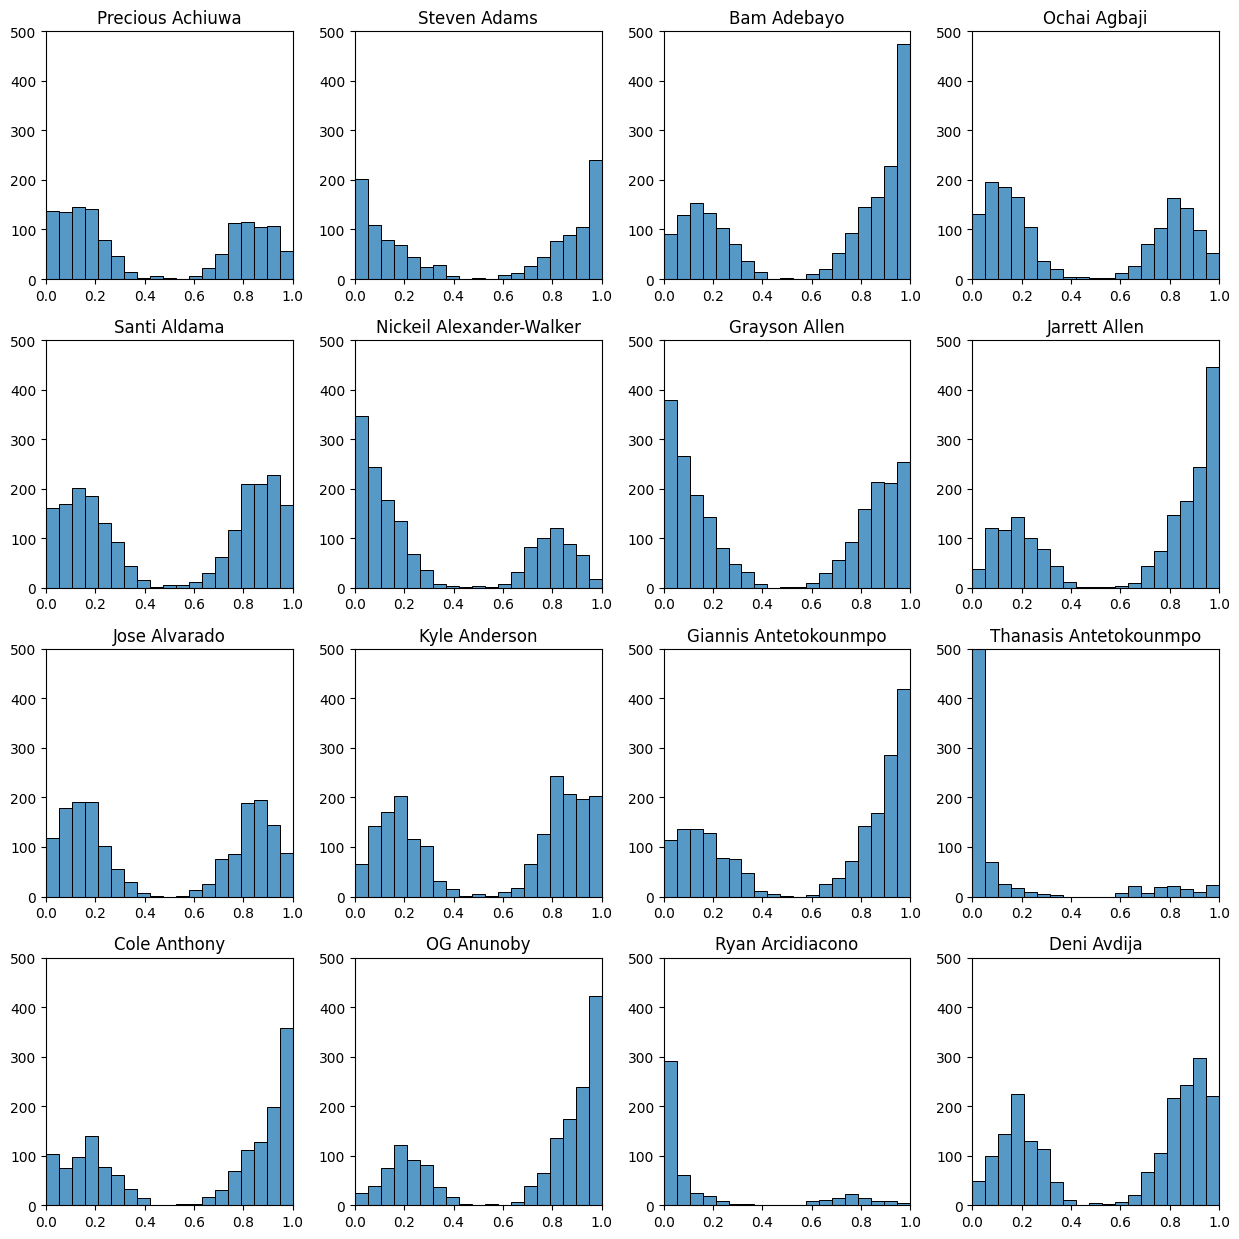

In [43]:
# make a collage
n = 4

fig, ax = plt.subplots(n,n, figsize=(12.5, 12.5))

plr_ids   = list(probs)
plr_probs = list(probs.values())

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id, plr_prob = plr_ids[k], plr_probs[k][0]

    graph = sns.histplot(plr_prob, bins=np.linspace(0, 1, 20), ax=ax[i, j])
    graph.set_xlim(0, 1)
    graph.set_ylim(0, 500)
    graph.set_ylabel('')
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()

# Compute Weighted Estimators

Now that we have propensity scores, we will use them for a few estimators of skill. Here, $\mu$ represents player skill.

## Inverse-Propensity Weighting

IPW is calculated like so. Define
- $p_i$ = Propensity score of stint $i$ (i.e. probability of presence)
- $t_i$ = 0 if absent, 1 if present
- $y_i$ = The PM of the stint (in the eyes of the player)

Then
$$
\mu_{\text{ipw}} = \dfrac{\sum t_i p_{i}^{-1} y_i}{\sum p_{i}^{-1}} - \dfrac{\sum (1 - t_i) (1 - p_i)^{-1} y_i}{\sum (1 - p_i)^{-1}}
$$

While this looks complicated, this is simply a difference of weighted averages, where the weights for each observation is $\frac{1}{p_i}$ if the player was present, and $\frac{1}{1 - p_i}$ if the player wasn't present. 

In other words, each stint is weighted by the inverse of the probability of being correct.

## Overlapping Weights

Using the same definitions as above, the overlapping estimator is defined as
$$
\mu_{\text{overlap}} = \dfrac{\sum t_i (1 - p_i) y_i}{\sum 1 - p_i} - \dfrac{\sum (1 - t_i) p_i y_i}{\sum p_i}
$$

Essentially, where IPW assigned weights based on the probability of being correct, overlapping weights assign weights based on the probability of being incorrect. This mainly upweights stints that can be in either treatment group (i.e. it upweights stints that could either have a player's presence, or could lack a player's presence).

## Doubly-Robust Estimators

Using both the propensity and PM models, we can compute the doubly-robust estimators for each player. 

Let $i$ be a stint. Define
- $y_i$ - True PM of stint $i$.
- $\hat{y}_{i}^{(0)}$ - Predicted outcome of PM, given absence of player.
- $\hat{y}_{i}^{(1)}$ - Predicted outcome of PM, given presence of player.
- $p_i$ - Propensity score of stint (i.e. probability of player presence)
- $t_i$ - Indicator of player presence. 0 = Absent, 1 = Present.

Note that the PMs are in the eyes of the player. Then the doubly robust estimators are defined as
$$
    \begin{align*}
        \text{DR}_0 &= \frac{\sum y_i (1 - t_i)}{\sum 1 - p_i} + \frac{\sum \hat{y}_{i}^{(0)} (t_i - p_i)}{\sum 1 - p_i} \\
        \text{DR}_1 &= \frac{\sum y_i t_i}{\sum p_i} - \frac{\sum \hat{y}_{i}^{(1)} (t_i - p_i)}{\sum p_i}
    \end{align*}
$$
Where $\text{DR}_0$ is the expected PM under absence, and $\text{DR}_1$ is the expected PM under presence. Thus, we can compute the player's skill by finding $\mu_{\text{DR}} = \text{DR}_1 - \text{DR}_0$

## Division by Zero

To prevent divisions by 0 in the IPW and DR estimators, $p_i$ is constrainted to be between $[\epsilon, 1-\epsilon]$ for some $\epsilon > 0$. This is carried over for the overlapping estimator for consistency. We use $\epsilon = 0.05$



In [50]:
eps = 5e-2 # probability threshold
ipw_estimators = {}
overlap_estimators = {}
dr_estimators = {}

for plr_id, model_stuff in prob_models.items():
    plr_data       = model_stuff[1]
    presence_probs = probs[plr_id][0] # the order of these probabilities matches the order of the player's game data
    pm             = plr_data['pm'] * game_presence.loc[plr_data.index, plr_id] # get pm in the eyes of the player
    true_presence  = design.loc[plr_data.index, plr_id].abs()
    
    # filter out extreme values
    presence_probs[presence_probs < eps] = eps
    presence_probs[presence_probs > 1 - eps] = 1 - eps

    ipw_on_weights  = 1 / presence_probs
    ipw_off_weights = 1 / (1 - presence_probs)
    ipw_estimators[plr_id]  = np.dot(pm, true_presence * ipw_on_weights) / ipw_on_weights.sum() \
                            - np.dot(pm, (1 -  true_presence) * ipw_off_weights) / ipw_off_weights.sum()
    
    overlap_on_weights  = 1 - presence_probs
    overlap_off_weights = presence_probs
    overlap_estimators[plr_id]  = np.dot(pm, true_presence * overlap_on_weights) / overlap_on_weights.sum() \
                                - np.dot(pm, (1 -  true_presence) * overlap_off_weights) / overlap_off_weights.sum()
    
    # predicted_pms: plr_id: (exposed_pms, rmse), (unexposed_pms, rmse)
    dr0 = (np.dot(pm, 1 - true_presence) + np.dot(predicted_pms[plr_id][1][0], true_presence - presence_probs)) / (1 - presence_probs).sum()
    dr1 = (np.dot(pm, true_presence) - np.dot(predicted_pms[plr_id][0][0], true_presence - presence_probs)) / presence_probs.sum()
    dr_estimators[plr_id] = dr1 - dr0


In [51]:
# add the data to existing results
results = pd.read_csv('../../results/ryurko_results.csv', index_col=0, dtype={'Player ID': str})
results['IPW PM'] = np.empty(len(results))
results['Overlap PM'] = np.empty(len(results))
results['DR PM'] = np.empty(len(results))

for plr_id, plr_ipw in ipw_estimators.items():
    results.loc[results['Player ID'] == plr_id, 'IPW PM'] = plr_ipw
    results.loc[results['Player ID'] == plr_id, 'Overlap PM'] = overlap_estimators[plr_id]
    results.loc[results['Player ID'] == plr_id, 'DR PM'] = dr_estimators[plr_id]

results.to_csv('../../results/ryurko_results.csv')

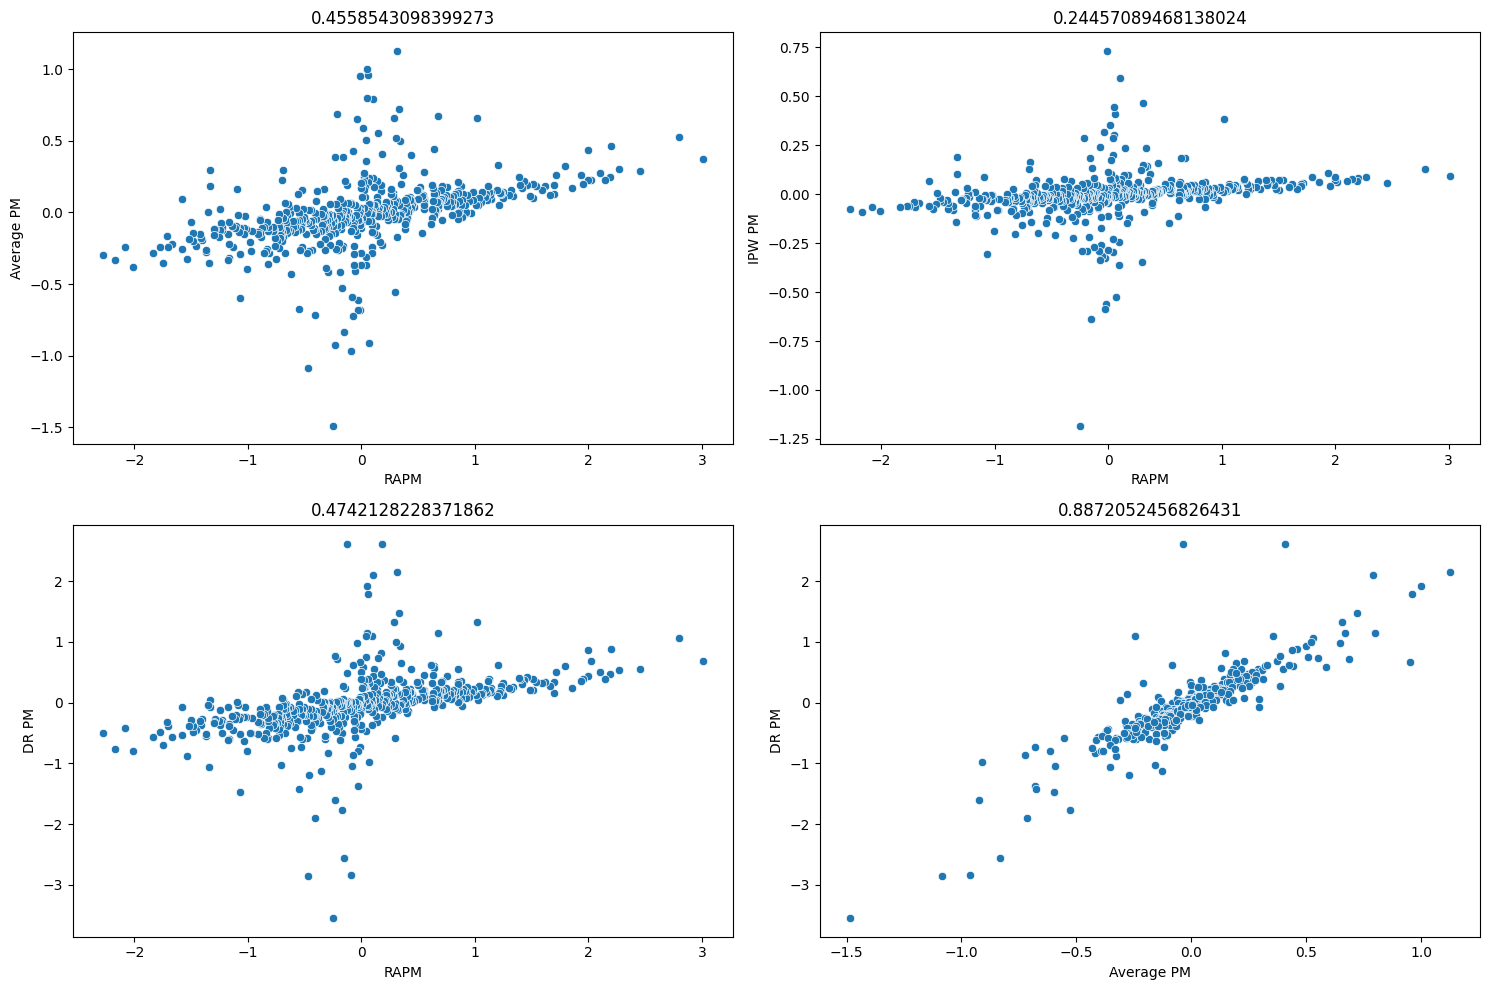

In [52]:
bools = results['RAPM'].abs() >= 0

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(results[bools], x='RAPM', y='Average PM', ax=ax[0, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Average PM']))
sns.scatterplot(results[bools], x='RAPM', y='IPW PM', ax=ax[0, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW PM']))
sns.scatterplot(results[bools], x='RAPM', y='DR PM', ax=ax[1, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'DR PM']))
sns.scatterplot(results[bools], x='Average PM', y='DR PM', ax=ax[1, 1]).set_title(results.loc[bools, 'Average PM'].corr(results.loc[bools, 'DR PM']))


fig.tight_layout()
fig.show()

0.8892802894977822


<Axes: xlabel='Average PM', ylabel='IPW PM'>

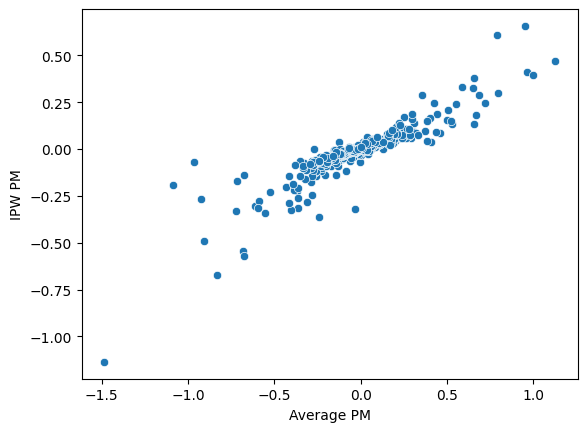

In [ ]:
print(results['Average PM'].corr(results['IPW PM']))

sns.scatterplot(results, x='Average PM', y='IPW PM')

In [ ]:
print(results['Average PM'].corr(results['RAPM']))


0.45585430983992736


In [22]:
results

,Player ID,Player Name,RAPM,Average PM,IPW PM,Overlap PM
156,203954,Joel Embiid,3.011352,0.373349,0.093322,0.086112
274,203999,Nikola Jokic,2.795283,0.529107,0.131249,0.120989
2,203110,Draymond Green,2.455016,0.288675,0.058418,0.101872
259,201950,Jrue Holiday,2.271931,0.306525,0.091626,0.085553
273,203932,Aaron Gordon,2.197510,0.462165,0.083587,0.109204
...,...,...,...,...,...,...
202,203115,Will Barton,-1.834715,-0.279167,-0.068036,-0.119043
331,1630197,Aleksej Pokusevski,-2.011774,-0.381854,-0.085613,-0.083552
224,1631095,Jabari Smith Jr.,-2.080260,-0.243384,-0.065175,-0.070006
130,1631323,Simone Fontecchio,-2.171379,-0.331522,-0.089867,-0.124576


# Analyze Importance of Features

Here, we investigate the importance of the input features into both the PM model and propensity models.

We will compute each feature's SHAP values.

ExactExplainer explainer: 1291it [00:32, 28.19it/s]                          
ExactExplainer explainer: 1167it [00:26, 27.36it/s]                          
ExactExplainer explainer: 1921it [00:46, 32.62it/s]                          
ExactExplainer explainer: 1525it [00:37, 29.35it/s]                          
ExactExplainer explainer: 2051it [00:53, 31.41it/s]                          
ExactExplainer explainer: 1542it [00:36, 31.10it/s]                          
ExactExplainer explainer: 2174it [00:53, 33.21it/s]                          
ExactExplainer explainer: 1799it [00:43, 31.69it/s]                          
ExactExplainer explainer: 1694it [00:41, 31.25it/s]                          
ExactExplainer explainer: 1924it [00:49, 31.37it/s]                          
ExactExplainer explainer: 1892it [00:45, 32.22it/s]                          
ExactExplainer explainer: 1094it [00:21, 26.58it/s]                          
ExactExplainer explainer: 1516it [00:35, 30.45it/s]             

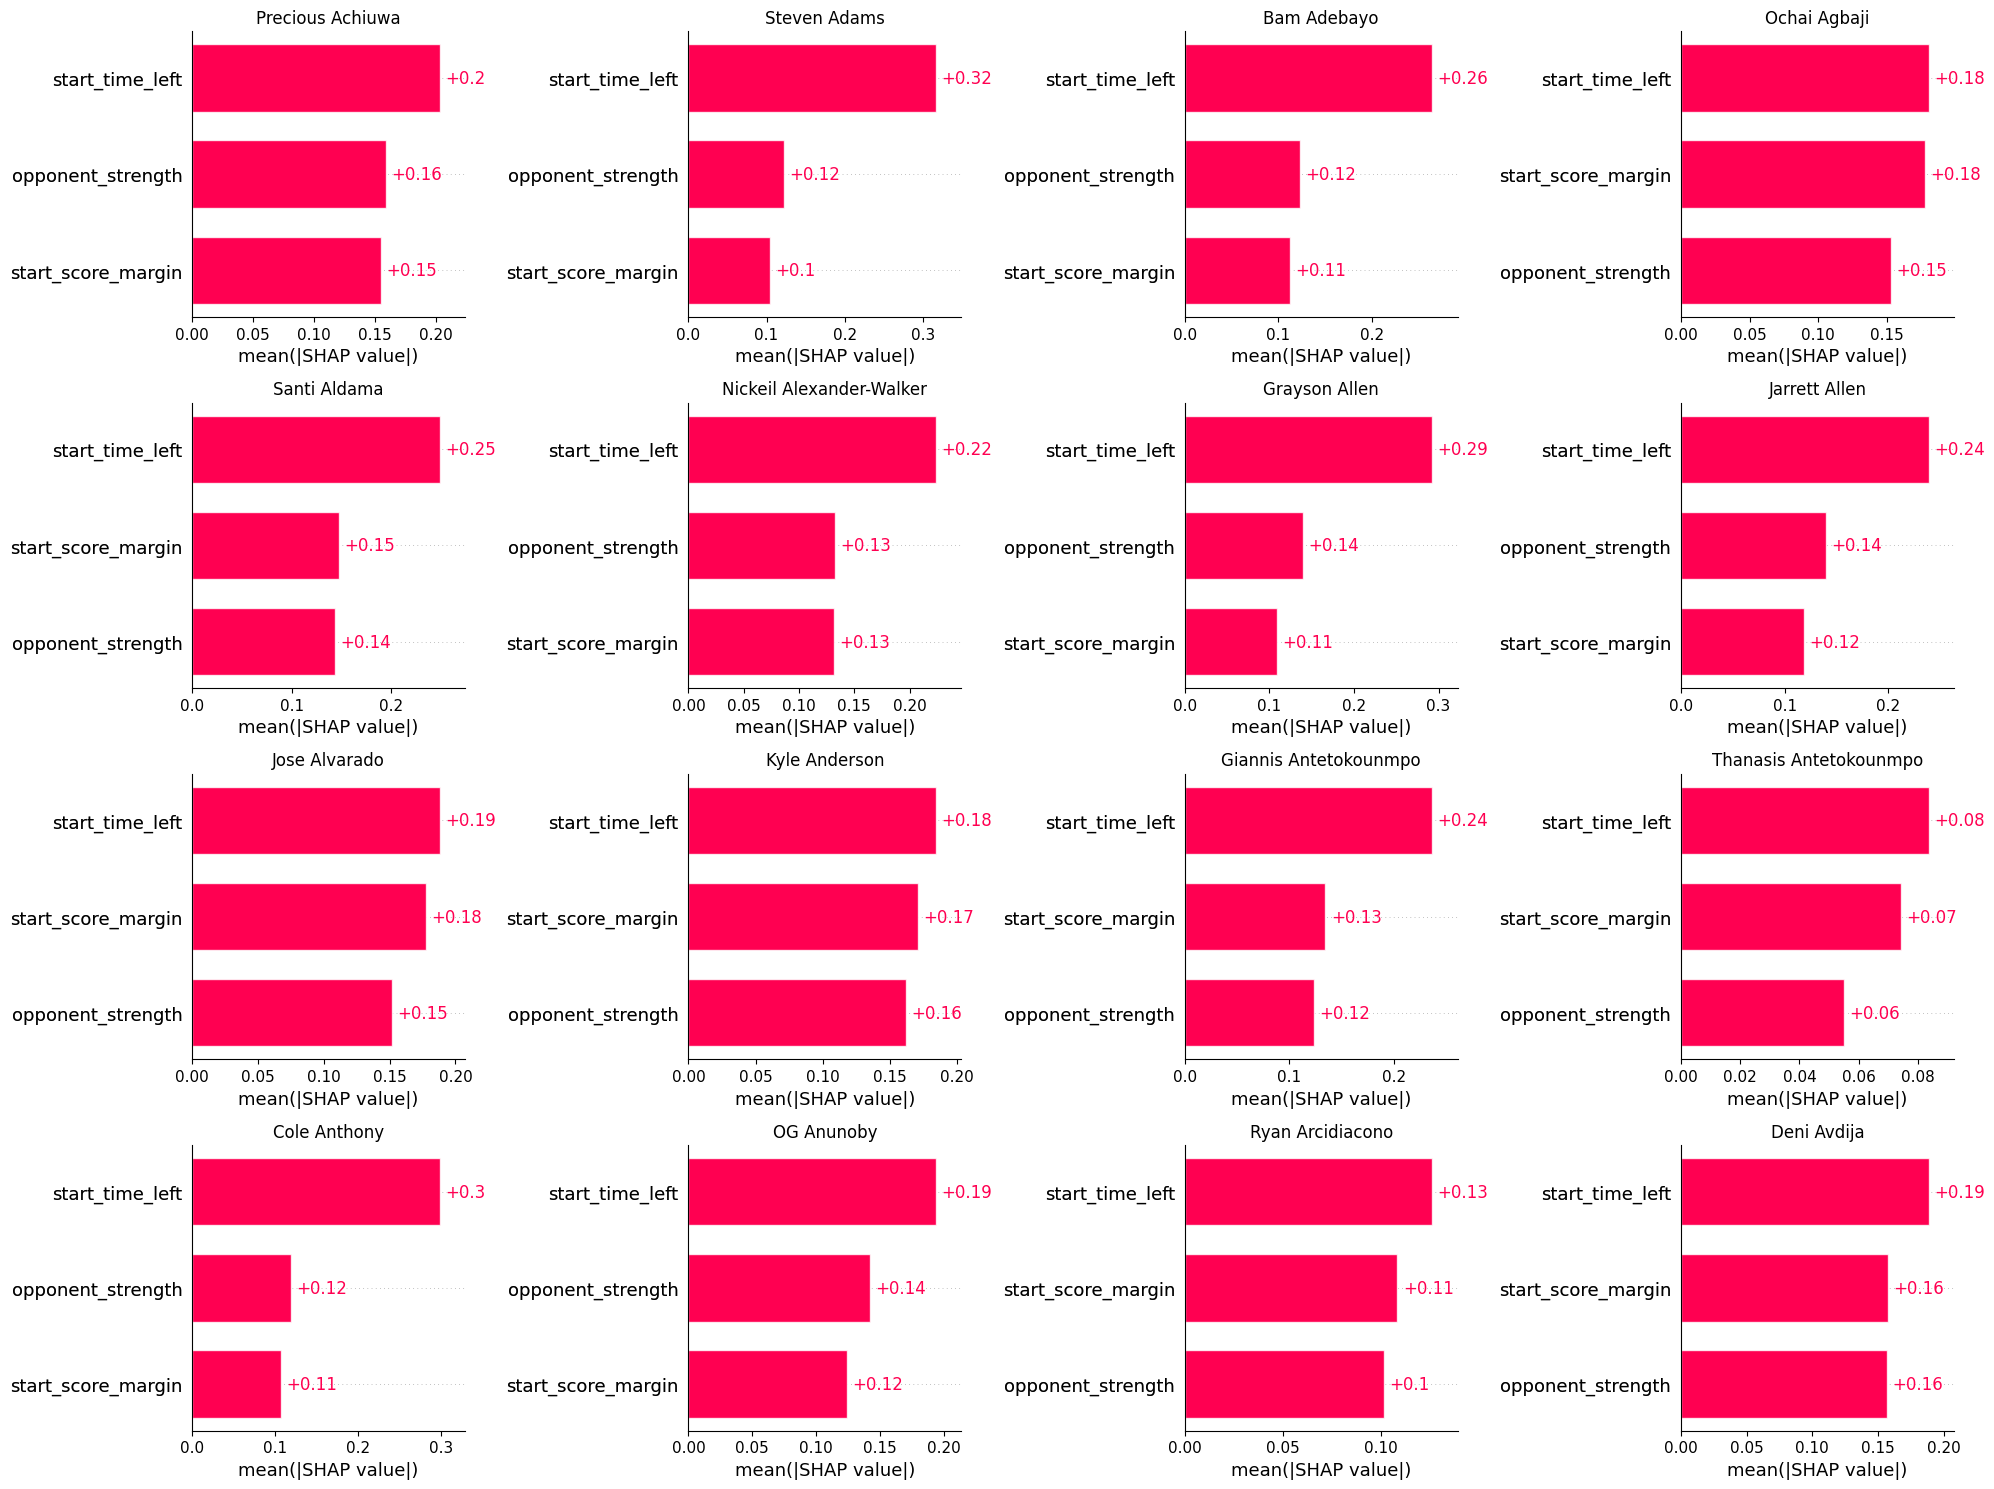

In [62]:
# random forest
n = 4

fig, ax = plt.subplots(n,n, figsize=(20, 15))
plr_ids = list(probs)

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask
    explainer   = shap.Explainer(plr_model.predict, subset)
    shap_values = explainer(plr_data)

    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()
